In [ ]:
# This notebook applies normalizing flows to the `purple-forest.csv.gz` color dataset.

# See `purple-forest.jpg` for a rendering of colors from the dataset, and `purple-forest-epoch-*.jpg` for example output that I've converted back to JPG.

In [42]:
import torch
import torch.nn as nn
import torch.autograd as grad
from torch.distributions import MultivariateNormal

import math
from flows import *

import pandas
import torch.utils.data

table = torch.tensor(pandas.read_csv("../datasets/purple-forest.csv.gz").values, dtype=torch.float32)
print(table)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

tensor([[ 0.0343, -0.0735,  0.6441],
        [-0.5966, -0.6806,  0.4833],
        [-0.1722, -0.4614,  0.8236],
        ...,
        [-0.3445, -0.3445,  0.6930],
        [-1.3788, -1.6563,  0.2523],
        [-0.7567, -0.9091,  0.4943]])


In [43]:
# Define a 3-dimensional flow with many Triangular matrix multiplies, intermediate quadratic non-linearities, and a logarithmic non-linearity
# normal_flows converts the source distribution into the Normal distribution with identity covariance
dim = 3
normal_flows = Flows(
    ScaleBiasFlow(dim),    
    SoftexpFlow(dim),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 3),

    ScaleBiasFlow(dim),    
    SoftlogFlow(),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 3),

    ScaleBiasFlow(dim),    
    SoftexpFlow(dim),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 3),

    ScaleBiasFlow(dim),    
    SoftlogFlow(),
    ScaleBiasFlow(dim),
    HouseholderQrConvolution(dim, 3),
    
    ScaleBiasFlow(dim),    
)

net = FlowModule(normal_flows, NegLogLikelihoodLoss(dim))
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)

print(list(net.parameters()))

[Parameter containing:
tensor([1., 1., 1.], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([2.7183, 2.7183, 2.7183], requires_grad=True), Parameter containing:
tensor([1., 1., 1.], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([[ 0.8601],
        [ 0.5579],
        [-0.5316]], requires_grad=True), Parameter containing:
tensor([[-2.7291],
        [-0.4473],
        [ 0.1866]], requires_grad=True), Parameter containing:
tensor([[ 0.8283],
        [-0.0173],
        [ 1.2427]], requires_grad=True), Parameter containing:
tensor([1., 1., 1.], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([1., 1., 1.], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [49]:
# The training loop!  With some additional debugging code if NaNs are detected in the loss function.
# This can happen due to the use of Sigmoid - where extreme values can saturate the gradients.
final_loss = 0.0
nan_data = torch.tensor([])
for batch in range(60):  #1oop over the dataset multiple times
    for _, data in enumerate(dataloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net(data[0])
        if loss != loss:
            nan_data = data
            print("Nan found during training.  Aborting")
            break
        
        loss.backward()
        optimizer.step()
        final_loss = loss
print("final loss: %.03f" % final_loss)

final loss: 1.258


In [51]:
# Print the trained network parameters
for f in normal_flows.flows:
    print(f)
    for name, param in f.named_parameters():
        print("  %s = %s" % (name, param.data))
    print()

ScaleBiasFlow()
  s = tensor([0.4384, 0.8097, 0.7166])
  b = tensor([ 0.3535,  0.0207, -0.3049])

SoftexpFlow()
  a = tensor([2.4143, 2.5047, 2.4758])

ScaleBiasFlow()
  s = tensor([1.3389, 0.9988, 1.2846])
  b = tensor([ 0.0303,  0.0630, -0.0706])

HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
    (2): HouseholderReflectionFlow()
  )
)
  r = tensor([[ 1.3254, -0.1262,  0.0483],
        [ 0.0000,  0.9926,  0.1301],
        [ 0.0000,  0.0000,  1.2477]])
  vs.0.v = tensor([[ 1.2800],
        [ 0.3891],
        [-0.4855]])
  vs.1.v = tensor([[-2.1834],
        [-0.8095],
        [ 0.2650]])
  vs.2.v = tensor([[0.8025],
        [0.1427],
        [1.2486]])

ScaleBiasFlow()
  s = tensor([1.2637, 1.5096, 0.9520])
  b = tensor([-0.0894,  0.0712, -0.0327])

SoftlogFlow()

ScaleBiasFlow()
  s = tensor([0.7736, 0.7605, 1.0478])
  b = tensor([-0.1659,  0.1875,  0.2913])

HouseholderQrConvolution(
  (vs): ModuleList(
    (0)

In [46]:
# Run the network in reverse to generate data, and export it to a CSV.
import pandas

outputs = MultivariateNormal(torch.zeros(dim), torch.eye(dim)).sample_n(1000)
inputs, log_det = normal_flows.backward(outputs)
pandas.DataFrame(inputs.detach().numpy()).to_csv('../datasets/purple-forest-output.csv', header=False, index=False)

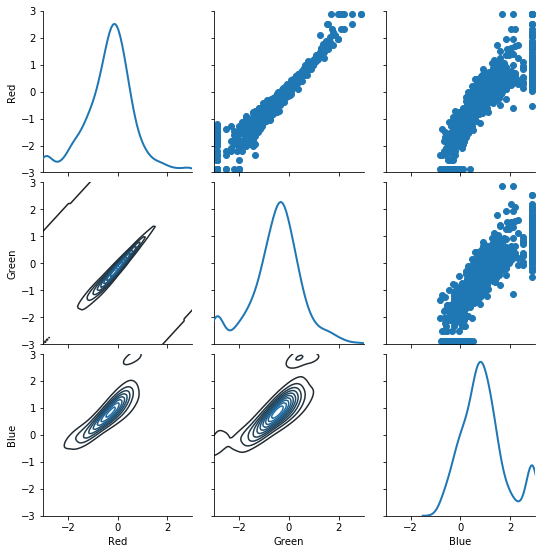

In [47]:
# Use Seaborn to generate X-Y plots on each pair of variables (from the source data)
import numpy
import seaborn
import matplotlib.pylab
import pandas
cols = ['Red', 'Green', 'Blue']
data = pandas.DataFrame(table[0:1000].numpy(), columns = cols)
g = seaborn.PairGrid(data)
g.map_upper(matplotlib.pylab.scatter)
g.map_diag(seaborn.kdeplot, lw=2, legend=False);
g.map_lower(seaborn.kdeplot)

g.set(xlim=(-3, 3), ylim=(-3, 3))

matplotlib.pylab.show()

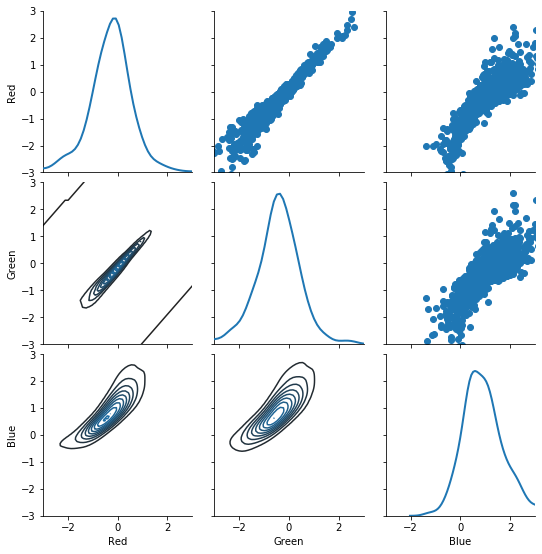

In [50]:
# Similar plots on generated data (from the trained model)
import numpy
import seaborn
import matplotlib.pylab
import pandas
cols = ['Red', 'Green', 'Blue']
data = pandas.DataFrame(inputs[0:1000].detach().numpy(), columns = cols)
g = seaborn.PairGrid(data)
g.map_upper(matplotlib.pylab.scatter)
g.map_diag(seaborn.kdeplot, lw=2, legend=False);
g.map_lower(seaborn.kdeplot)

g.set(xlim=(-3, 3), ylim=(-3, 3))

matplotlib.pylab.show()